In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder

# Model import
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# EDA

讀取資料，做資料探索

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing/bank-full.csv' ,sep =';')

# df # 45211 rows × 17 columns

In [ ]:
df.info()

In [ ]:
# Pie charts for data type distribution
df.dtypes.value_counts().plot.pie()

print(df.dtypes.value_counts())

In [ ]:
import missingno as msno

msno.bar(df)

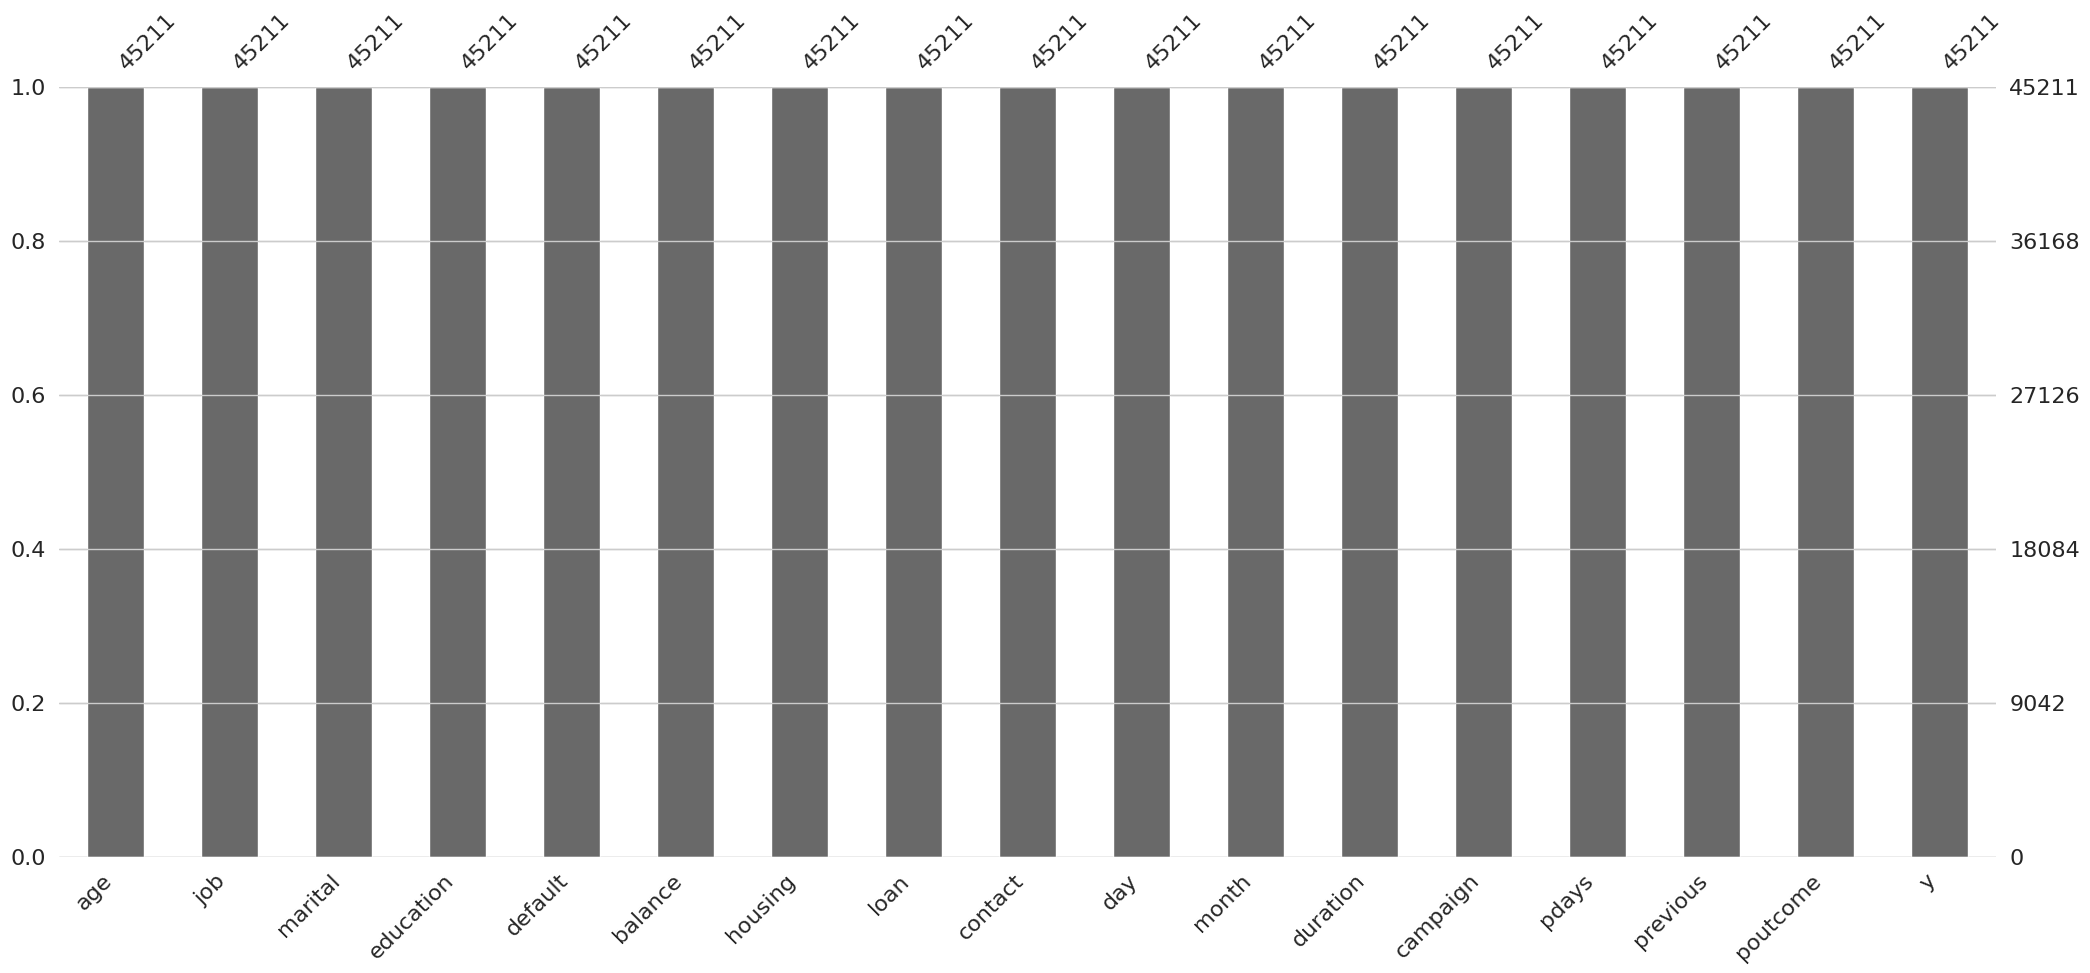

圖表顯示，該資料集無缺失值

In [ ]:
# Numerical statistics
df.describe()

In [ ]:
# Object statistics
df.describe(include=['object'])

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(14, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

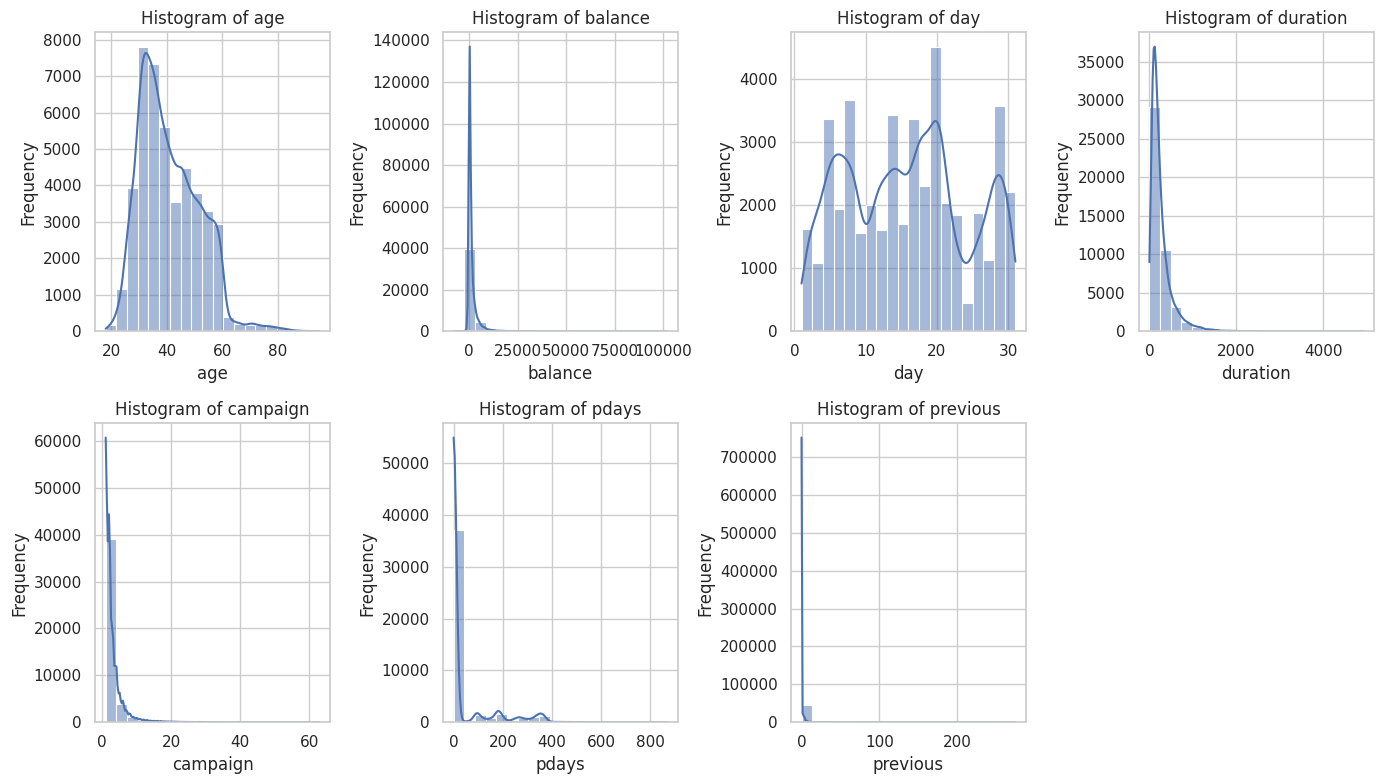

In [ ]:
plt.figure(figsize=(15, 25))
df.plot(kind="box", subplots=True, layout=(3, 3), figsize=(15, 25))
plt.show()

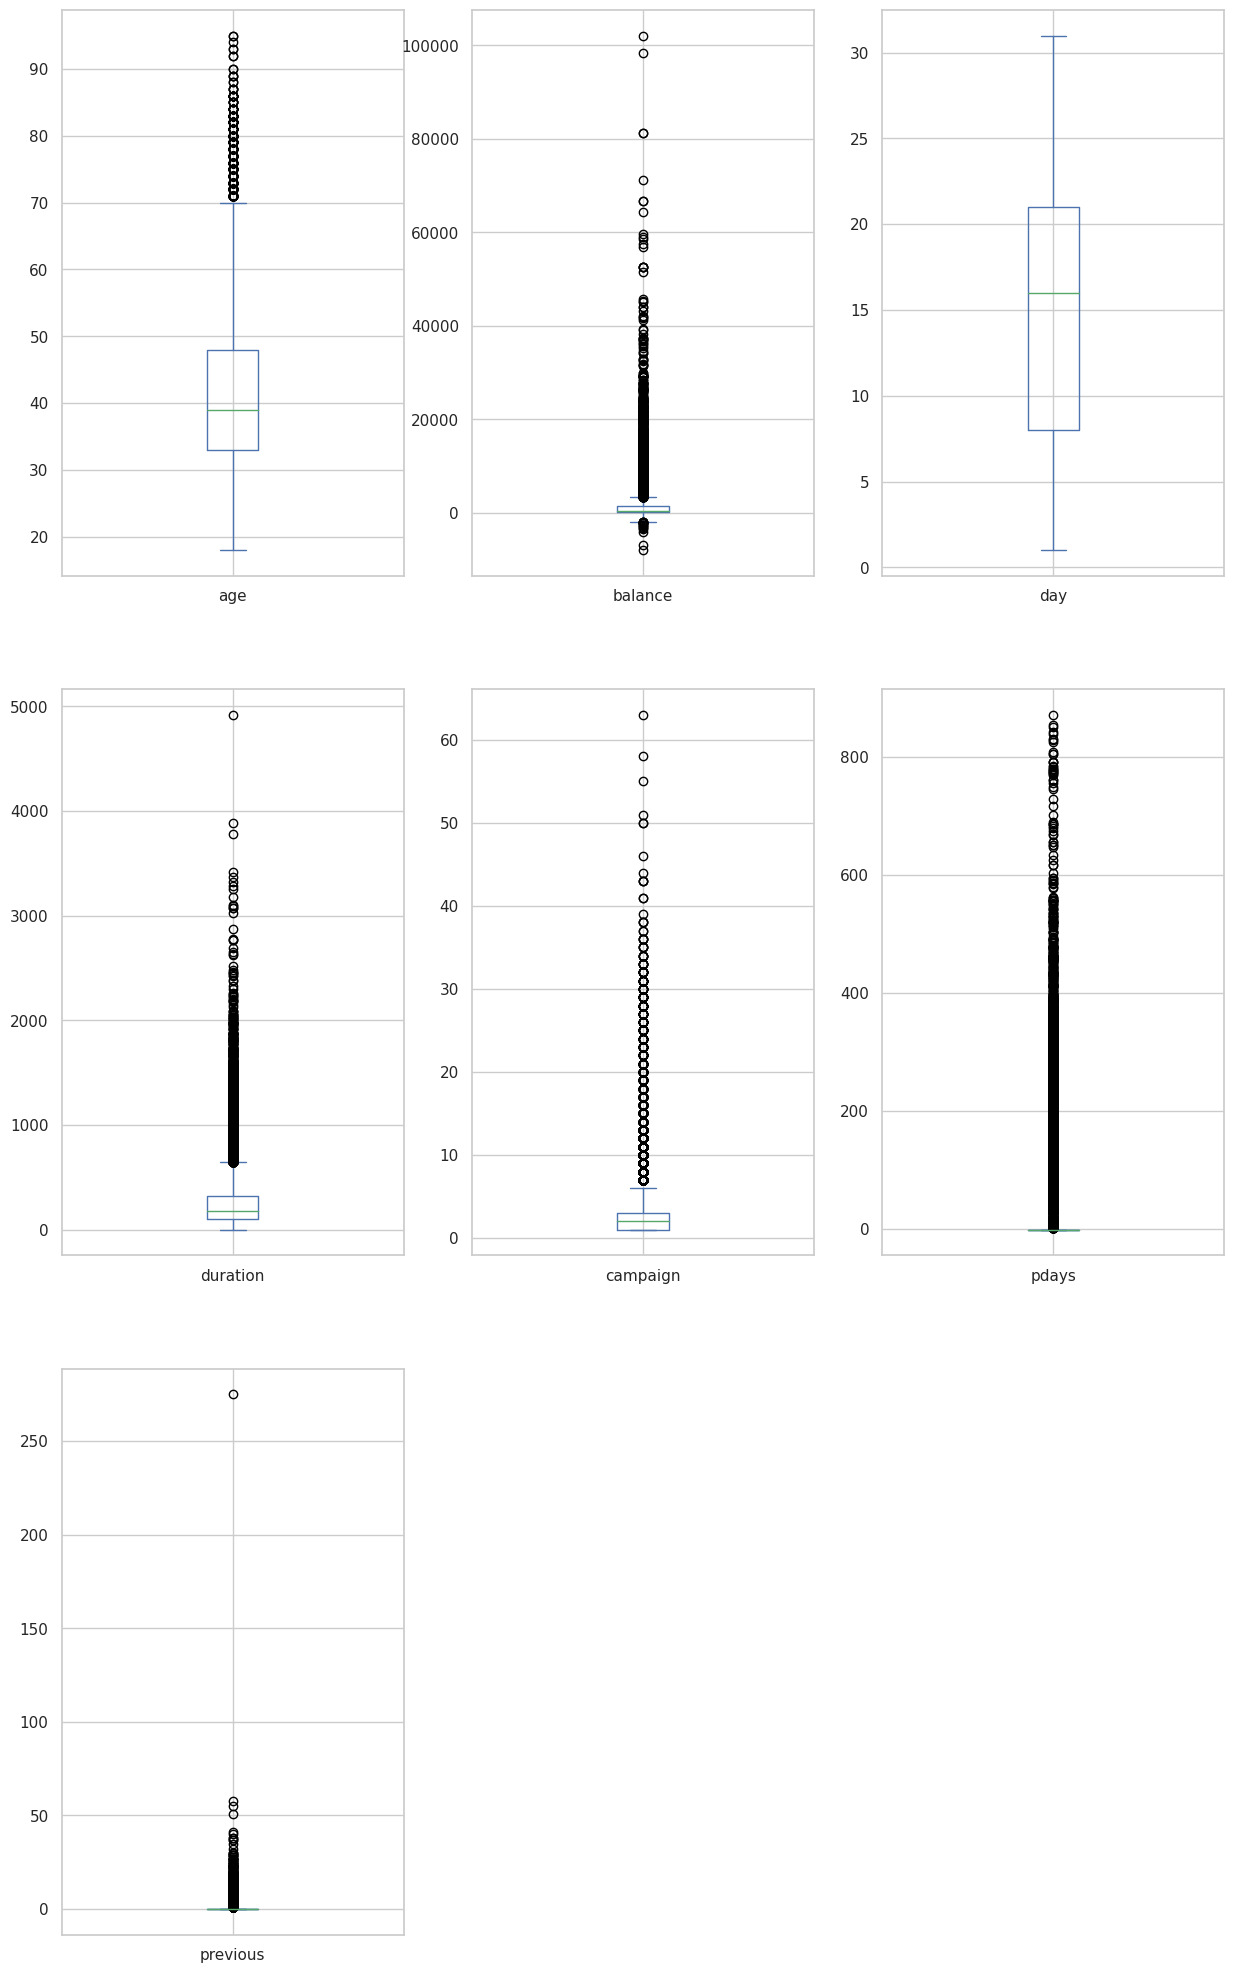

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(df['y'].value_counts()) # No:39922(88.3%) ,Yes:5289(11.7%)

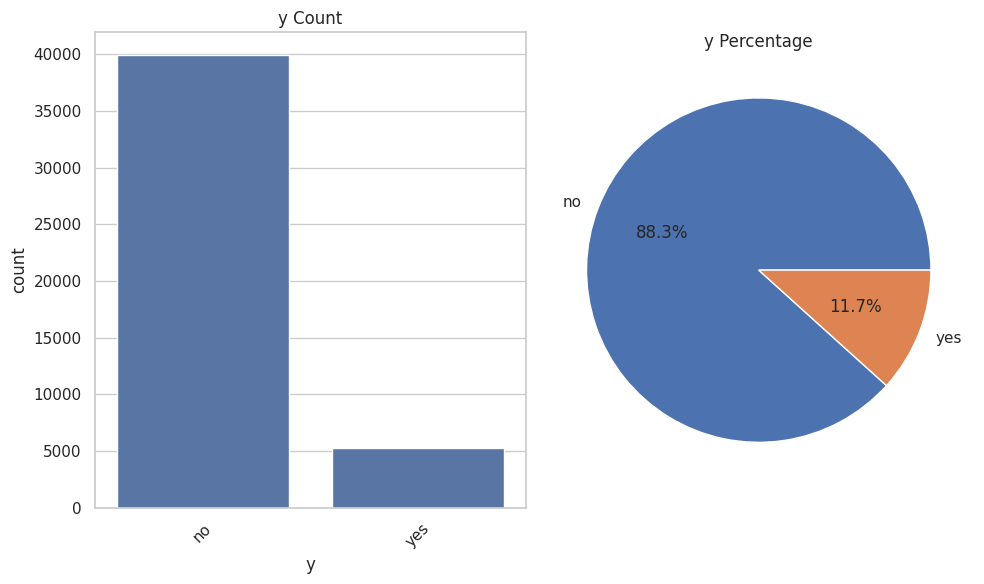

得圖表和輸出內容得知,No:39922(88.3%) ,Yes:5289(11.7%)

# Processing Data

刪除特定欄位

In [ ]:
# Calculate the percentage of 'unknown' values in row
unknown_percentages_in_rows = (df == 'unknown').mean(axis=1) * 100

row_with_highest_percentage = unknown_percentages_in_rows.idxmax()
highest_percentage_row = unknown_percentages_in_rows.max()

print("\nPercentage of 'unknown' values in each row:")
print(unknown_percentages_in_rows)

print("\nRow with the highest percentage of 'unknown' values:")
print(f"Row: {row_with_highest_percentage}, Percentage: {highest_percentage_row:.2f}%")

In [ ]:
df = df.drop(4)

In [ ]:
# delete_columns = ['pdays', 'previous', 'poutcome']
delete_columns = ['poutcome']
df = df.drop(delete_columns, axis=1)

In [ ]:
df

In [ ]:
# Numerical statistics
df.describe()

# Feature Engineering

將特徵和標籤做特徵工程轉換

In [ ]:
use_columns = ['y']
df_copy = df.copy()
label_encoder = LabelEncoder()
for col in use_columns:
    df_copy[col + '_encoded'] = label_encoder.fit_transform(df[col])
    original_values = df_copy[col].unique()
    encoded_values = df_copy[col + '_encoded'].unique()
    print(f"Original values for column '{col}': {original_values}")
    print(f"Encoded values for column '{col}': {encoded_values}")
    print()

Original values for column 'y': ['no' 'yes']

Encoded values for column 'y': [0 1]

In [ ]:
# 標籤y做LabelEncoder
lb_encoder = LabelEncoder()
df['y'] = lb_encoder.fit_transform(df['y'])

# 類別特徵欄位做OrdinalEncoder
cat_columns = df.select_dtypes(include='object').columns
or_encoder = OrdinalEncoder()
df[cat_columns] = or_encoder.fit_transform(df[cat_columns])

# Hetmap

做熱力圖,顯示欄位間的相關性，並將絕對值化後的相關性列出

In [ ]:
corr = df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

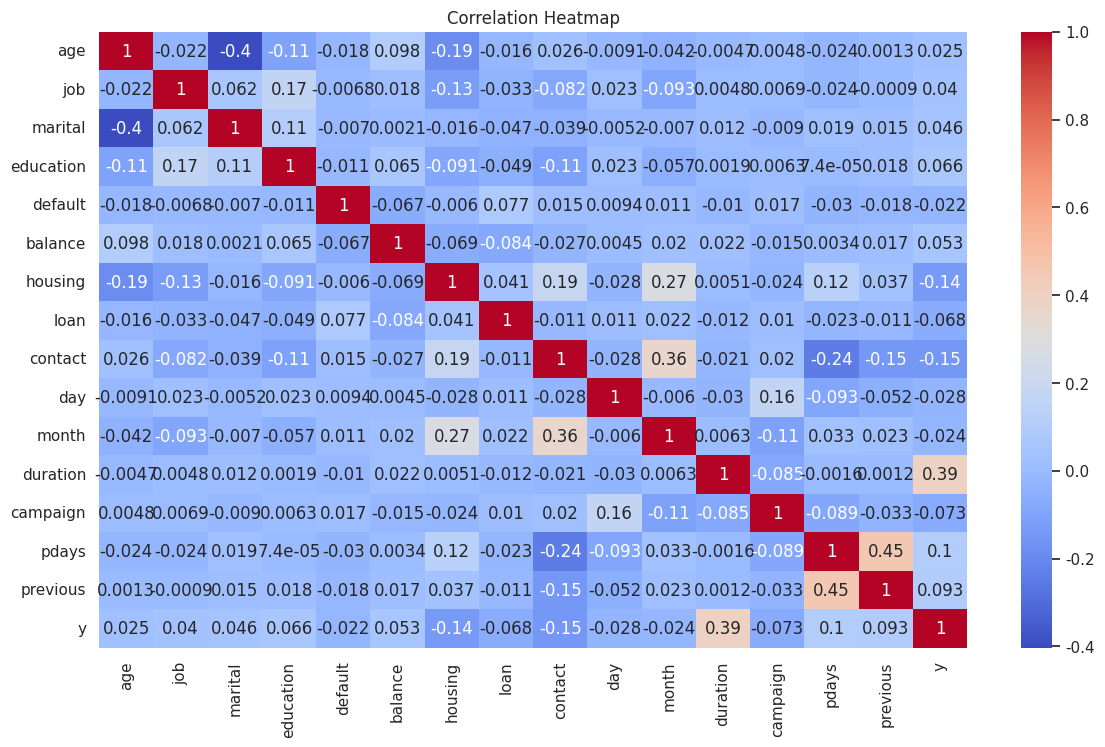

In [ ]:
correlation_matrix = df.corr().abs()
top_correlations = correlation_matrix['y'].sort_values(ascending=False).head(10)
print(top_correlations)

# Train Test Split

資料分割，將資料集拆分為訓練集和測試集

In [ ]:
X = df.drop(columns=['y'])
# X = df[['duration' ,'housing' ,'contact' ,'balance' ,'education']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

列出訓練資料和測試資料的標籤個數

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

0: 27972, 1: 3675}

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 11949, 1: 1614}

# Model

簡單的套用模型，因此不做模型訓練來尋找參數

In [ ]:
svm_model = SVC(random_state=42)
# svm_model  = DecisionTreeClassifier(random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(svm_model, X_train, X_test, y_train, y_test)

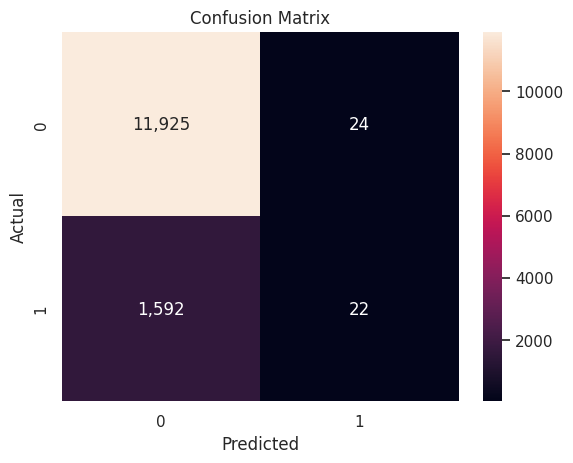

y - 顧客是否已認購定期存款

*   有認購定期存款資料總共有1614筆，其中22筆被成功辨識出來，1592筆沒有被辨識出來。
*   沒有認購的資料總共有11949筆，其中有24筆資料沒認購被預測為有認購，剩下的11925筆預測皆正確。

訓練和測試的結果都非常糟糕，可重新檢查資料集做詳細處理，像是針對異常值或是處理標籤類別不平衡的問題，改變特徵工程的做法，或是嘗試改用Ensemble learning algorithm，待結果有明顯的改善後，再用GridSearchCV或Optuna來尋找模型參數等，進一步提升模型的能力。

# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
plot_learning_curve(svm_model, X_train, y_train)